The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Language Models and the Dataset

:label:`sec_language_model`


In :numref:`sec_text_preprocessing`, we see how to map text data into tokens, and these tokens can be viewed as a time series of discrete observations. Assuming the tokens in a text of length $T$ are in turn $x_1, x_2, \ldots, x_T$, then, in the discrete time series, $x_t$($1 \leq t \leq T$) can be considered as the output or label of timestep $t$. Given such a sequence, the goal of a language model is to estimate the probability

$$p(x_1, x_2, \ldots, x_T).$$

Language models are incredibly useful. For instance, an ideal language model would be able to generate natural text just on its own, simply by drawing one word at a time $w_t \sim p(w_t \mid w_{t-1}, \ldots, w_1)$. Quite unlike the monkey using a typewriter, all text emerging from such a model would pass as natural language, e.g., English text. Furthermore, it would be sufficient for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments. Clearly we are still very far from designing such a system, since it would need to *understand* the text rather than just generate grammatically sensible content.

Nonetheless language models are of great service even in their limited form. For instance, the phrases "to recognize speech" and "to wreck a nice beach" sound very similar. This can cause ambiguity in speech recognition, ambiguity that is easily resolved through a language model which rejects the second translation as outlandish. Likewise, in a document summarization algorithm it is worth while knowing that "dog bites man" is much more frequent than "man bites dog", or that "I want to eat grandma" is a rather disturbing statement, whereas "I want to eat, grandma" is much more benign.

## Estimating a Language Model

The obvious question is how we should model a document, or even a sequence of words. We can take recourse to the analysis we applied to sequence models in the previous section. Let us start by applying basic probability rules:

$$p(w_1, w_2, \ldots, w_T) = p(w_1) \prod_{t=2}^T p(w_t  \mid  w_1, \ldots, w_{t-1}).$$

For example, the probability of a text sequence containing four tokens consisting of words and punctuation would be given as:

$$p(\mathrm{Statistics}, \mathrm{is}, \mathrm{fun}, \mathrm{.}) =  p(\mathrm{Statistics}) p(\mathrm{is}  \mid  \mathrm{Statistics}) p(\mathrm{fun}  \mid  \mathrm{Statistics}, \mathrm{is}) p(\mathrm{.}  \mid  \mathrm{Statistics}, \mathrm{is}, \mathrm{fun}).$$

In order to compute the language model, we need to calculate the
probability of words and the conditional probability of a word given
the previous few words, i.e., language model parameters. Here, we
assume that the training dataset is a large text corpus, such as all
Wikipedia entries, [Project Gutenberg](https://en.wikipedia.org/wiki/Project_Gutenberg), or all text posted online on the
web. The probability of words can be calculated from the relative word
frequency of a given word in the training dataset.

For example, $p(\mathrm{Statistics})$ can be calculated as the
probability of any sentence starting with the word "statistics". A
slightly less accurate approach would be to count all occurrences of
the word "statistics" and divide it by the total number of words in
the corpus. This works fairly well, particularly for frequent
words. Moving on, we could attempt to estimate

$$\hat{p}(\mathrm{is} \mid \mathrm{Statistics}) = \frac{n(\mathrm{Statistics~is})}{n(\mathrm{Statistics})}.$$

Here $n(w)$ and $n(w, w')$ are the number of occurrences of singletons
and pairs of words respectively. Unfortunately, estimating the
probability of a word pair is somewhat more difficult, since the
occurrences of "Statistics is" are a lot less frequent. In
particular, for some unusual word combinations it may be tricky to
find enough occurrences to get accurate estimates. Things take a turn for the worse for 3-word combinations and beyond. There will be many plausible 3-word combinations that we likely will not see in our dataset. Unless we provide some solution to give such word combinations nonzero weight, we will not be able to use these as a language model. If the dataset is small or if the words are very rare, we might not find even a single one of them.

A common strategy is to perform some form of Laplace smoothing. We already
encountered this in our discussion of
naive Bayes in :numref:`sec_naive_bayes` where the solution was to
add a small constant to all counts. This helps with singletons, e.g., via

$$\begin{aligned}
	\hat{p}(w) & = \frac{n(w) + \epsilon_1/m}{n + \epsilon_1}, \\
	\hat{p}(w' \mid w) & = \frac{n(w, w') + \epsilon_2 \hat{p}(w')}{n(w) + \epsilon_2}, \\
	\hat{p}(w'' \mid w',w) & = \frac{n(w, w',w'') + \epsilon_3 \hat{p}(w',w'')}{n(w, w') + \epsilon_3}.
\end{aligned}$$

Here the coefficients $\epsilon_i > 0$ determine how much we use the
estimate for a shorter sequence as a fill-in for longer
ones. Moreover, $m$ is the total number of words we encounter. The
above is a rather primitive variant of what Kneser-Ney smoothing
and Bayesian nonparametrics can accomplish. See e.g., :cite:`Wood.Gasthaus.Archambeau.ea.2011` for more detail of how to accomplish
this. Unfortunately, models like this get unwieldy rather quickly
for the following reasons. First, we need to store all counts.
Second, this entirely ignores the meaning of the words. For
instance, *"cat"* and *"feline"* should occur in related contexts.
It is quite difficult to adjust such models to additional contexts,
whereas, deep learning based language models are well suited to
take this into account.  Last, long word
sequences are almost certain to be novel, hence a model that simply
counts the frequency of previously seen word sequences is bound to
perform poorly there.


## Markov Models and $n$-grams

Before we discuss solutions involving deep learning, we need some more terminology and concepts. Recall our discussion of Markov Models in the previous section. Let us apply this to language modeling. A distribution over sequences satisfies the Markov property of first order if $p(w_{t+1} \mid w_t, \ldots, w_1) = p(w_{t+1} \mid w_t)$. Higher orders correspond to longer dependencies. This leads to a number of approximations that we could apply to model a sequence:

$$
\begin{aligned}
p(w_1, w_2, w_3, w_4) &=  p(w_1) p(w_2) p(w_3) p(w_4),\\
p(w_1, w_2, w_3, w_4) &=  p(w_1) p(w_2  \mid  w_1) p(w_3  \mid  w_2) p(w_4  \mid  w_3),\\
p(w_1, w_2, w_3, w_4) &=  p(w_1) p(w_2  \mid  w_1) p(w_3  \mid  w_1, w_2) p(w_4  \mid  w_2, w_3).
\end{aligned}
$$

The probability formulae that involve one, two, and three variables are typically referred to as unigram, bigram, and trigram models respectively. In the following, we will learn how to design better models.

## Natural Language Statistics

Let us see how this works on real data. We construct a vocabulary based on the time machine data similar to :numref:`sec_text_preprocessing` and print the top $10$ most frequent words.

In [1]:
from d2l import torch as d2l
import torch
import random

tokens = d2l.tokenize(d2l.read_time_machine())
vocab = d2l.Vocab(tokens)
print(vocab.token_freqs[:10])

[('the', 2261), ('', 1282), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443)]


As we can see, the most popular words are actually quite boring to look at. They are often referred to as [stop words](https://en.wikipedia.org/wiki/Stop_words) and thus filtered out. That said, they still carry meaning and we will use them nonetheless. However, one thing that is quite clear is that the word frequency decays rather rapidly. The $10^{\mathrm{th}}$ most frequent word is less than $1/5$ as common as the most popular one. To get a better idea we plot the graph of the word frequency.

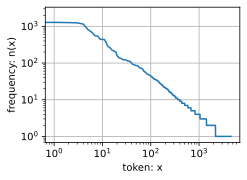

In [2]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

We are on to something quite fundamental here: the word frequency decays rapidly in a well defined way. After dealing with the first four words as exceptions ('the', 'i', 'and', 'of'), all remaining words follow a straight line on a log-log plot. This means that words satisfy [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) which states that the item frequency is given by

$$n(x) \propto (x + c)^{-\alpha} \text{ and hence }
\log n(x) = -\alpha \log (x+c) + \mathrm{const.}$$

This should already give us pause if we want to model words by count statistics and smoothing. After all, we will significantly overestimate the frequency of the tail, also known as the infrequent words. But what about the other word combinations (such as bigrams, trigrams, and beyond)? Let us see whether the bigram frequency behaves in the same manner as the unigram frequency.

In [3]:
bigram_tokens = [[pair for pair in zip(
    line[:-1], line[1:])] for line in tokens]
bigram_vocab = d2l.Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

[(('of', 'the'), 297), (('in', 'the'), 161), (('i', 'had'), 126), (('and', 'the'), 104), (('i', 'was'), 104), (('the', 'time'), 97), (('it', 'was'), 94), (('to', 'the'), 81), (('as', 'i'), 75), (('of', 'a'), 69)]


One thing is notable here. Out of the 10 most frequent word pairs, 9 are composed of stop words and only one is relevant to the actual book---"the time". Furthermore, let us see whether the trigram frequency behaves in the same manner.

In [4]:
trigram_tokens = [[triple for triple in zip(line[:-2], line[1:-1], line[2:])]
                  for line in tokens]
trigram_vocab = d2l.Vocab(trigram_tokens)
print(trigram_vocab.token_freqs[:10])

[(('the', 'time', 'traveller'), 53), (('the', 'time', 'machine'), 24), (('the', 'medical', 'man'), 22), (('it', 'seemed', 'to'), 14), (('it', 'was', 'a'), 14), (('i', 'began', 'to'), 13), (('i', 'did', 'not'), 13), (('i', 'saw', 'the'), 13), (('here', 'and', 'there'), 12), (('i', 'could', 'see'), 12)]


Last, let us visualize the token frequency among these three gram models: unigrams, bigrams, and trigrams.

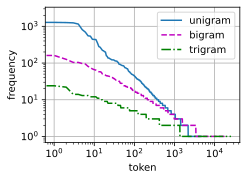

In [5]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token',
         ylabel='frequency', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

The graph is quite exciting for a number of reasons. First, beyond unigram words, also sequences of words appear to be following Zipf's law, albeit with a lower exponent, depending on  sequence length. Second, the number of distinct n-grams is not that large. This gives us hope that there is quite a lot of structure in language. Third, many n-grams occur very rarely, which makes Laplace smoothing rather unsuitable for language modeling. Instead, we will use deep learning based models.

## Training Data Preparation

Before introducing the model, let us assume we will use a neural network to train a language model. Now the question is how to read minibatches of examples and labels at
random. Since sequence data is by its very nature sequential, we need to address
the issue of processing it. We did so in a rather ad-hoc manner when we
introduced in :numref:`sec_sequence`. Let us formalize this a bit.

In :numref:`fig_timemachine_5gram`, we visualized several possible ways to obtain 5-grams in a sentence, here a token is a character. Note that we have quite some freedom since we could pick an arbitrary offset.

![Different offsets lead to different subsequences when splitting up text.](../img/timemachine-5gram.svg)
:label:`fig_timemachine_5gram`

Hence, which one should we pick? In fact, all of them are equally good. But if we pick all offsets we end up with rather redundant data due to overlap, particularly if the sequences are long. Picking just a random set of initial positions is no good either since it does not guarantee uniform coverage of the array. For instance, if we pick $n​$ elements at random out of a set of $n​$ with random replacement, the probability for a particular element not being picked is $(1-1/n)^n \to e^{-1}​$. This means that we cannot expect uniform coverage this way. Even randomly permuting a set of all offsets does not offer good guarantees. Instead we can use a simple trick to get both *coverage* and *randomness*: use a random offset, after which one uses the terms sequentially. We describe how to accomplish this for both random sampling and sequential partitioning strategies below.

### Random Sampling

The following code randomly generates a minibatch from the data each time. Here, the batch size `batch_size` indicates the number of examples in each minibatch and `num_steps` is the length of the sequence (or timesteps if we have a time series) included in each example.
In random sampling, each example is a sequence arbitrarily captured on the original sequence. The positions of two adjacent random minibatches on the original sequence are not necessarily adjacent. The target is to predict the next character based on what we have seen so far, hence the labels are the original sequence, shifted by one character.

In [6]:
#@save
def seq_data_iter_random(corpus, batch_size, num_steps):
    # Offset the iterator over the data for uniform starts
    corpus = corpus[random.randint(0, num_steps):]
    # Subtract 1 extra since we need to account for label
    num_examples = ((len(corpus) - 1) // num_steps)
    example_indices = list(range(0, num_examples * num_steps, num_steps))
    random.shuffle(example_indices)

    def data(pos):
        # This returns a sequence of the length num_steps starting from pos
        return corpus[pos: pos + num_steps]

    # Discard half empty batches
    num_batches = num_examples // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Batch_size indicates the random examples read each time
        batch_indices = example_indices[i:(i+batch_size)]
        X = [data(j) for j in batch_indices]
        Y = [data(j + 1) for j in batch_indices]
        yield torch.Tensor(X), torch.Tensor(Y)

Let us generate an artificial sequence from 0 to 30. We assume that
the batch size and numbers of timesteps are 2 and 6
respectively. This means that depending on the offset we can generate between 4 and 5 $(x, y)$ pairs. With a minibatch size of 2, we only get 2 minibatches.

In [7]:
my_seq = list(range(30))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.]]) 
Y: tensor([[ 1.,  2.,  3.,  4.,  5.,  6.],
        [ 7.,  8.,  9., 10., 11., 12.]])
X:  tensor([[12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.]]) 
Y: tensor([[13., 14., 15., 16., 17., 18.],
        [19., 20., 21., 22., 23., 24.]])


### Sequential Partitioning

In addition to random sampling of the original sequence, we can also make the positions of two adjacent random minibatches adjacent in the original sequence.

In [8]:
#@save
def seq_data_iter_consecutive(corpus, batch_size, num_steps):
    # Offset for the iterator over the data for uniform starts
    offset = random.randint(0, num_steps)
    # Slice out data - ignore num_steps and just wrap around
    num_indices = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.Tensor(corpus[offset:offset+num_indices])
    Ys = torch.Tensor(corpus[offset+1:offset+1+num_indices])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_batches * num_steps, num_steps):
        X = Xs[:, i:(i+num_steps)]
        Y = Ys[:, i:(i+num_steps)]
        yield X, Y

Using the same settings, print input `X` and label `Y` for each minibatch of examples read by sequential partitioning. The positions of two adjacent minibatches on the original sequence are adjacent.

In [9]:
for X, Y in seq_data_iter_consecutive(my_seq, batch_size=2, num_steps=6):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1.,  2.,  3.,  4.,  5.,  6.],
        [15., 16., 17., 18., 19., 20.]]) 
Y: tensor([[ 2.,  3.,  4.,  5.,  6.,  7.],
        [16., 17., 18., 19., 20., 21.]])
X:  tensor([[ 7.,  8.,  9., 10., 11., 12.],
        [21., 22., 23., 24., 25., 26.]]) 
Y: tensor([[ 8.,  9., 10., 11., 12., 13.],
        [22., 23., 24., 25., 26., 27.]])


Now we wrap the above two sampling functions to a class so that we can use it as a Gluon data iterator later.

In [10]:
#@save
class SeqDataLoader:
    """A iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_consecutive
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

Last, we define a function `load_data_time_machine` that returns both the data iterator and the vocabulary, so we can use it similarly as other functions with `load_data` prefix.

In [11]:
#@save
def load_data_time_machine(batch_size, num_steps, use_random_iter=False,
                           max_tokens=10000):
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## Summary

* Language models are an important technology for natural language processing.
* $n$-grams provide a convenient model for dealing with long sequences by truncating the dependence.
* Long sequences suffer from the problem that they occur very rarely or never.
* Zipf's law governs the word distribution for not only unigrams but also the other $n$-grams.
* There is a lot of structure but not enough frequency to deal with infrequent word combinations efficiently via Laplace smoothing.
* The main choices for sequence partitioning are picking between consecutive and random sequences.
* Given the overall document length, it is usually acceptable to be slightly wasteful with the documents and discard half-empty minibatches.

## Exercises

1. Suppose there are $100,000$ words in the training dataset. How much word frequency and multi-word adjacent frequency does a four-gram need to store?
1. Review the smoothed probability estimates. Why are they not accurate? Hint: we are dealing with a contiguous sequence rather than singletons.
1. How would you model a dialogue?
1. Estimate the exponent of Zipf's law for unigrams, bigrams, and trigrams.
1. What other minibatch data sampling methods can you think of?
1. Why is it a good idea to have a random offset?
    * Does it really lead to a perfectly uniform distribution over the sequences on the document?
    * What would you have to do to make things even more uniform?
1. If we want a sequence example to be a complete sentence, what kinds of problems does this introduce in minibatch sampling? Why would we want to do this anyway?


## [Discussions](https://discuss.mxnet.io/t/2361)

![](../img/qr_language-models-and-dataset.svg)